# Auswertung I3W

Die Ergebnisse des Trainings wurden hier abgelegt:

In [5]:
path_ray_results = "/home/thorsten/ray_results/IntersectionExample/"
folder_results = "PPO_IntersectionEnv-v0_0_2019-02-18_19-10-10pejxqepw"

## A) Auswertung des Trainings
Auswertung der csv, die während des Trainings erstellt worden ist.

In [6]:
filename_trainingprogress = path_ray_results \
                            + folder_results \
                            + "/progress.csv"

episodes_per_iteration = 20

In [7]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv(filename_trainingprogress,sep=',',header=0)
list(data)

['episodes_total',
 'config',
 'time_this_iter_s',
 'time_since_restore',
 'node_ip',
 'hostname',
 'episode_reward_mean',
 'date',
 'episode_reward_min',
 'time_total_s',
 'pid',
 'timesteps_this_iter',
 'episodes_this_iter',
 'num_metric_batches_dropped',
 'timestamp',
 'timesteps_since_restore',
 'iterations_since_restore',
 'custom_metrics',
 'episode_len_mean',
 'experiment_id',
 'info',
 'episode_reward_max',
 'done',
 'timesteps_total',
 'training_iteration',
 'policy_reward_mean']

Text(0.5, 1.0, 'Training LaneChangeAccelPOEnv_speed PPO')

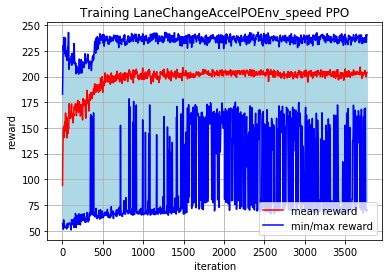

In [9]:
episode_reward_min = data[['episode_reward_min']].values
episode_reward_mean = data[['episode_reward_mean']].values
episode_reward_max = data[['episode_reward_max']].values

episodes_total = data[['episodes_total']].values/episodes_per_iteration

plt.plot(episodes_total,
         episode_reward_min,
         c='b')
plt.plot(episodes_total,
         episode_reward_mean,
         c='r',
         label='mean reward')
plt.plot(episodes_total,
         episode_reward_max,
         c='b',
         label='min/max reward')
plt.fill_between(np.squeeze(episodes_total),
                 np.squeeze(episode_reward_min),
                 np.squeeze(episode_reward_max),
                 color='lightblue')
plt.legend(loc='lower right')
plt.xlabel('iteration')
plt.ylabel('reward')
plt.grid()
plt.title('Training LaneChangeAccelPOEnv_speed PPO')

## B) Test durchführen

Um bei jedem rollout eine andere Startposition zu nutzen, muss im Ergebniss Ordner in *parms.json* der Parameter *starting_position_shuffle* auf *true* gesetzt werden.

Löschen der alten Ergebnisse:

In [6]:
import shutil
shutil.rmtree(path_ray_results+folder_results+"/test_time_rollout")

Ausführen des Visualisierungsskripts, dort kann auch die logdatei angepasst werden.

In [31]:
! python /home/thorsten/flow_2/flow/flow/visualize/visualizer_rllib_log_I3W.py /home/thorsten/ray_results/IntersectionExample/PPO_IntersectionEnv-v0_0_2019-02-18_19-10-10pejxqepw 600 --num-rollouts 20 --render_mode False

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-19_12-50-29_26882/logs.
Waiting for redis server at 127.0.0.1:25960 to respond...
Waiting for redis server at 127.0.0.1:58420 to respond...
Starting the Plasma object store with 6.5546633210000005 GB memory using /tmp.

View the web UI at http://localhost:8890/notebooks/ray_ui.ipynb?token=7679cc65c85bcd8ec88aacd853fe1ab1484bd71d6627a8eb

True
testtesttest
Created LogSyncer for /home/thorsten/ray_results/PPO_IntersectionEnv-v0_2019-02-19_12-50-29m7mhs311 -> None
2019-02-19 12:50:29,870	WARNING ppo.py:137 -- By default, observations will be normalized with MeanStdFilter
Loading configuration... done.
Success.
 Starting SUMO on port 36931
Loading configuration... done.
16.98740022282246
19.42270350839373
2019-02-19 12:50:33,198	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/home/thorsten/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradien

## C) Test auswerten

Speicherort der in B) erzeugten log-Dateien:

In [32]:
# default:
folder_logs = path_ray_results + folder_results + "/test_time_rollout/"

# anderer Ort:
#folder_logs = hier/und/dort/

### C1) Laden und lesen der log-Dateien

In [33]:
import glob
filenames_log = glob.glob( folder_logs + "/log_*.csv")

csvList = []

for file_ in filenames_log:
    df = pd.read_csv(file_,index_col=None, header=0)
    csvList.append(df)

actions_1 = []
actions_2 = []
veh_speeds_1 = []
veh_speeds_2 = []
veh_poss_1 = []
veh_poss_2 = []
curr_rewards = []
times = []

for csv in csvList:
    actions_1.append(csv[['action_acc_1']].values)
    actions_2.append(csv[['action_acc_2']].values)
    veh_speeds_1.append(csv[['veh_speed_1']].values)
    veh_speeds_2.append(csv[['veh_speed_2']].values)
    veh_poss_1.append(csv[['veh_pos_1']].values)
    veh_poss_2.append(csv[['veh_pos_2']].values)
    curr_rewards.append(csv[['curr_reward']].values)
    times.append(np.arange(csv[['action_acc_1']].values.size)/10)

### C2) Vergleich der Action beider Fahrzeuge

Text(0.5, 1.0, 'Vergleich der Action beider Fahrzeuge (rolling Avg)')

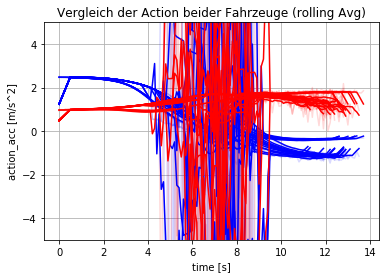

In [34]:
N_RA = 10
pltAlpha = 0.15

# print action
for time, action_1 in zip(times,actions_1):
    plt.plot(time[:-1],
             action_1[:-1],
             c='b',
             alpha=pltAlpha)
for time, action_2 in zip(times,actions_2):
    plt.plot(time[:-1],
             action_2[:-1],
             c='r',
             alpha=pltAlpha)

# print action with rolling avg
for time, action_1 in zip(times,actions_1):
    action_1_RA = np.convolve(action_1[:,0],np.ones((N_RA,))/N_RA,mode='same')
    plt.plot(time[:-1],
             action_1_RA[:-1],
             c='b')
for time, action_2 in zip(times,actions_2):
    action_2_RA = np.convolve(action_2[:,0],np.ones((N_RA,))/N_RA,mode='same')
    plt.plot(time[:-1],
             action_2_RA[:-1],
             c='r')    
    
plt.xlabel('time [s]')
plt.ylabel('action_acc [m/s^2]')
plt.grid()
plt.ylim(-5,5)
plt.title('Vergleich der Action beider Fahrzeuge (rolling Avg)')

### C3) Vergleich der Geschwindigkeit beider Fahrzeuge

Text(0.5, 1.0, 'Vergleich der Geschwindigkeit beider Fahrzeuge')

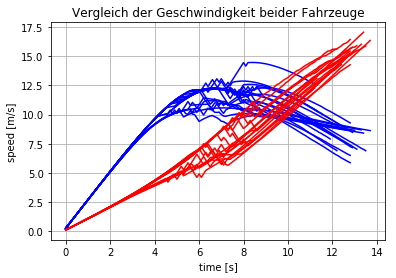

In [35]:
for time, veh_speed_1 in zip(times,veh_speeds_1):
    plt.plot(time[:-1],
             veh_speed_1[:-1],
             c='b')
for time, veh_speed_2 in zip(times,veh_speeds_2):
    plt.plot(time[:-1],
             veh_speed_2[:-1],
             c='r')
plt.xlabel('time [s]')
plt.ylabel('speed [m/s]')
plt.grid()
plt.title('Vergleich der Geschwindigkeit beider Fahrzeuge')

### C4) Position beider Fahrzeuge

Text(0.5, 1.0, 'Vergleich der Position beider Fahrzeuge')

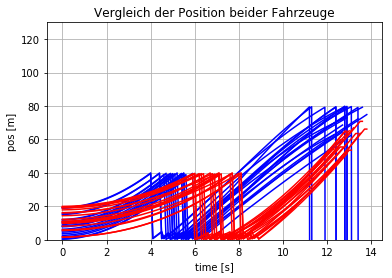

In [36]:
for time, veh_pos_1 in zip(times,veh_poss_1):
    plt.plot(time,
             veh_pos_1,
             c='b')
for time, veh_pos_2 in zip(times,veh_poss_2):
    plt.plot(time,
             veh_pos_2,
             c='r')
plt.ylim(0,130)
plt.xlabel('time [s]')
plt.ylabel('pos [m]')
plt.grid()
plt.title('Vergleich der Position beider Fahrzeuge')

### C5) Reward

Text(0.5, 1.0, 'Reward')

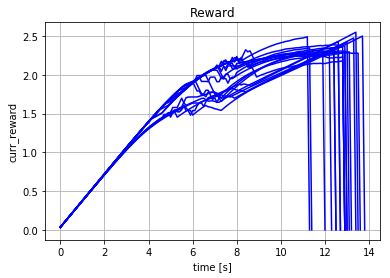

In [37]:
for time, curr_reward in zip(times,curr_rewards):
    plt.plot(time[:],
             curr_reward[:],
             c='b')
plt.xlabel('time [s]')
plt.ylabel('curr_reward')
plt.ylim()
plt.grid()
plt.title('Reward')

In [59]:
! python /home/thorsten/flow_2/flow/flow/visualize/visualizer_rllib_log_I3W.py --help

usage: visualizer_rllib_log_I3W.py [-h] [--run RUN]
                                   [--num-rollouts NUM_ROLLOUTS]
                                   [--emission-to-csv] [--evaluate]
                                   [--render_mode RENDER_MODE] [--save_render]
                                   [--horizon HORIZON]
                                   result_dir checkpoint_num

[Flow] Evaluates a reinforcement learning agent given a checkpoint.

positional arguments:
  result_dir            Directory containing results
  checkpoint_num        Checkpoint number.

optional arguments:
  -h, --help            show this help message and exit
  --run RUN             The algorithm or model to train. This may refer to the
                        name of a built-on algorithm (e.g. RLLib's DQN or
                        PPO), or a user-defined trainable function or class
                        registered in the tune registry. Required for results
                        trained with flow-0.2.0 

In [60]:
! python /home/thorsten/flow_2/flow/flow/visualize/visualizer_rllib_log_I3W.py /home/thorsten/ray_results/IntersectionExample/PPO_IntersectionEnv-v0_0_2019-02-18_19-10-10pejxqepw 800 --render_mode drgb

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-19_12-00-49_24329/logs.
Waiting for redis server at 127.0.0.1:29877 to respond...
Waiting for redis server at 127.0.0.1:27536 to respond...
Starting the Plasma object store with 6.5546633210000005 GB memory using /tmp.

View the web UI at http://localhost:8888/notebooks/ray_ui.ipynb?token=d5000982098ea5bc8007374f752fc0d58d2b31acebe18236

False
testtesttest
Created LogSyncer for /home/thorsten/ray_results/PPO_IntersectionEnv-v0_2019-02-19_12-00-49zobe6fqb -> None
2019-02-19 12:00:49,944	WARNING ppo.py:137 -- By default, observations will be normalized with MeanStdFilter
Loading configuration... done.
Success.
 Starting SUMO on port 50899
Loading configuration... done.
3.6130231680791636
8.252207924539306
2019-02-19 12:00:51,176	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/home/thorsten/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradi